# notebook mnist

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from torch import *

#let me be on my mac
def cuda(self, device=None, non_blocking=False) : return self
torch.Tensor.cuda = cuda

In [3]:
from lib.callbacks import *
from lib.model import *
from lib.data import *
from lib.optimizers import *
from pathlib import Path

## MNIST data

In [4]:
x_train,y_train,x_valid,y_valid = get_mnist_data(Path("/Users/kasparlund/.fastai/data/mnist.pkl.gz"))
x_train,x_valid   = normalize_to(x_train,x_valid)

x_train.mean(),x_train.std()

(tensor(-7.6999e-06), tensor(1.))

In [5]:
in_features         = 1
nh,bs,out_features  = 50,512,y_train.max().item()+1
train_ds,valid_ds   = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
train_dl, valid_dl  = ( DataLoader( train_ds, batch_size=bs, shuffle=True), 
                        DataLoader(valid_ds,  batch_size=bs*2) )
data                = DataBunch( train_dl, valid_dl )

In [20]:
mnist_view = view_tfm(1,28,28)
layers_sizes = [8,16,32,32]
loss_func = F.cross_entropy
sched     = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 
cbfs_base = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback,
             partial(ParamScheduler, 'lr', sched),             
             partial(BatchTransformXCallback, tfm = mnist_view) ]

## mnist without kaiming initialization

In [16]:
cbfs  = cbfs_base.copy() + [LR_Finder]
model = get_cnn_model(layers_sizes, in_features, out_features, partial(conv_layer,bn=False) )
learn = Learner( model, data, loss_func, opt=sgd_opt(model.parameters(), lr=0.4), cb_funcs=cbfs)
%time learn.fit(1)

CPU times: user 17.1 s, sys: 2.79 s, total: 19.9 s
Wall time: 2.89 s


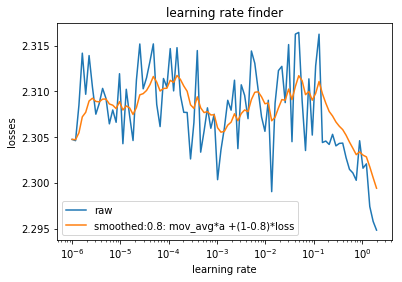

(None, None)

In [17]:
learn.find_subcription_by_cls(LR_Finder).plot_loss(0,7),plt.show()
#learn.find_subcription_by_cls(LR_Finder).plot_lr()

In [21]:
#Training: create model again because current LRFInd does not restore settings in model and opt
cbfs      = cbfs_base.copy()+[Recorder, partial(AvgStatsCallback,[accuracy])]
#model     = get_cnn_model(layers_sizes, in_features, out_features, conv_layer) 
model     = get_cnn_model(layers_sizes, in_features, out_features, partial(conv_layer,bn=False) )

learn     = Learner( model, data, loss_func,opt=sgd_opt(model.parameters(), lr=0.4), cb_funcs=cbfs)
%time learn.fit(4)

train: [1.92495578125, tensor(0.3216)]
valid: [0.53862861328125, tensor(0.8607)]
train: [0.320778984375, tensor(0.9018)]
valid: [0.1391767578125, tensor(0.9570)]
train: [0.13485484375, tensor(0.9590)]
valid: [0.10591798095703125, tensor(0.9694)]
train: [0.098192734375, tensor(0.9703)]
valid: [0.0928260498046875, tensor(0.9718)]
CPU times: user 1min 13s, sys: 16.1 s, total: 1min 29s
Wall time: 13.2 s


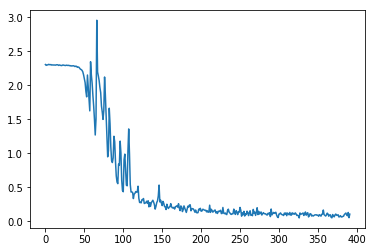

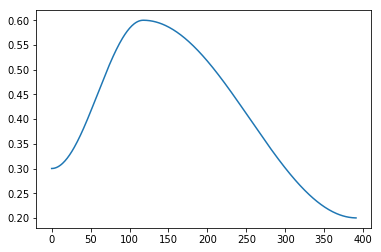

tensor(0.1198)

In [22]:
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.loss

## mnist with hooks

In [23]:
sched     = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)]) 
cbfs_base = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback,
             partial(BatchTransformXCallback, tfm = mnist_view) ]

train: [2.107100625, tensor(0.2506)]
valid: [1.2346599609375, tensor(0.6262)]
train: [0.54266046875, tensor(0.8251)]
valid: [0.216790625, tensor(0.9351)]
train: [0.21055572265625, tensor(0.9367)]
valid: [0.17046220703125, tensor(0.9490)]
train: [0.14714775390625, tensor(0.9549)]
valid: [0.125779296875, tensor(0.9613)]


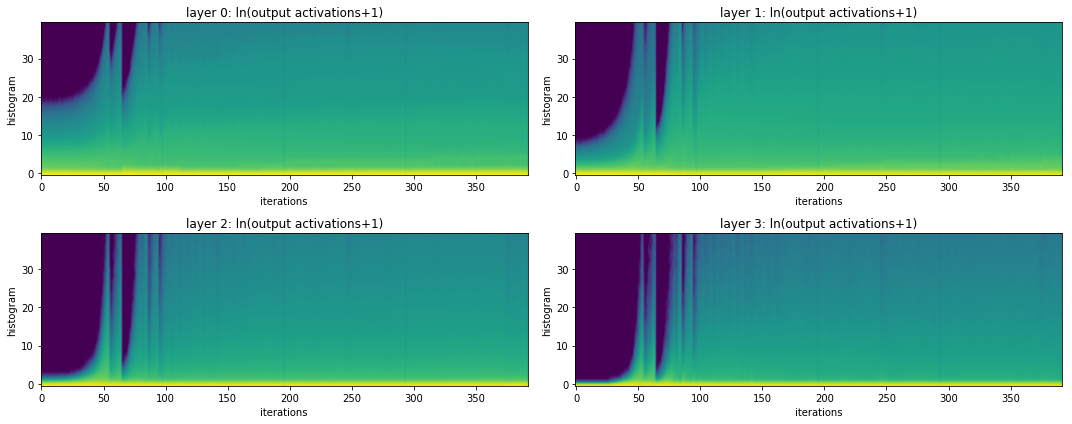

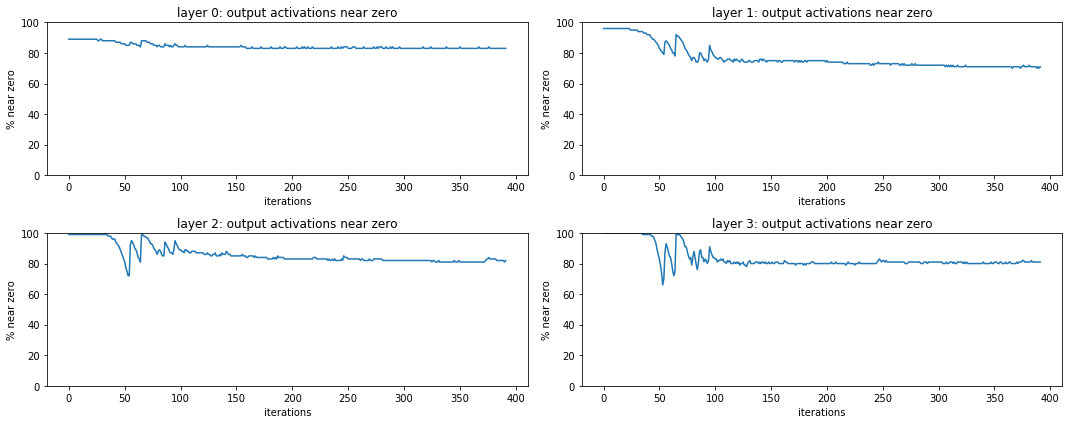

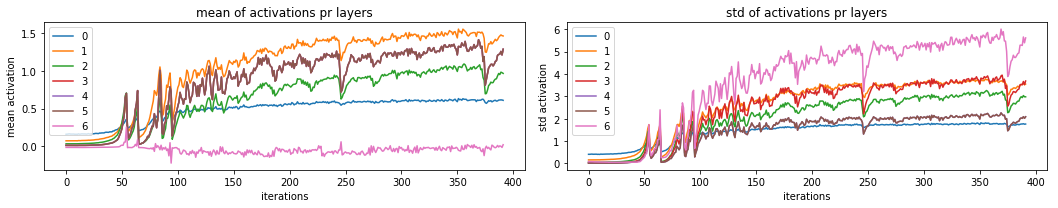

In [24]:
cbfs  = cbfs_base.copy() + [Recorder, partial(AvgStatsCallback,[accuracy]) ] 
model = get_cnn_model(layers_sizes, in_features, out_features, partial(conv_layer,bn=False) )
learn = Learner( model, data, loss_func,opt=sgd_opt(model.parameters(),lr=0.4), cb_funcs=cbfs)
with Hooks(model, append_stats) as hooks: 
    learn.fit(4)
    plot_layer_stats( hooks )

## mnist with hooks and kaiming initialization

train: [1.0567715625, tensor(0.6663)]
valid: [0.33912568359375, tensor(0.8977)]
train: [0.206315078125, tensor(0.9377)]
valid: [0.16163363037109374, tensor(0.9507)]
train: [0.136595, tensor(0.9581)]
valid: [0.113762939453125, tensor(0.9658)]
train: [0.1004196875, tensor(0.9693)]
valid: [0.1000943115234375, tensor(0.9698)]


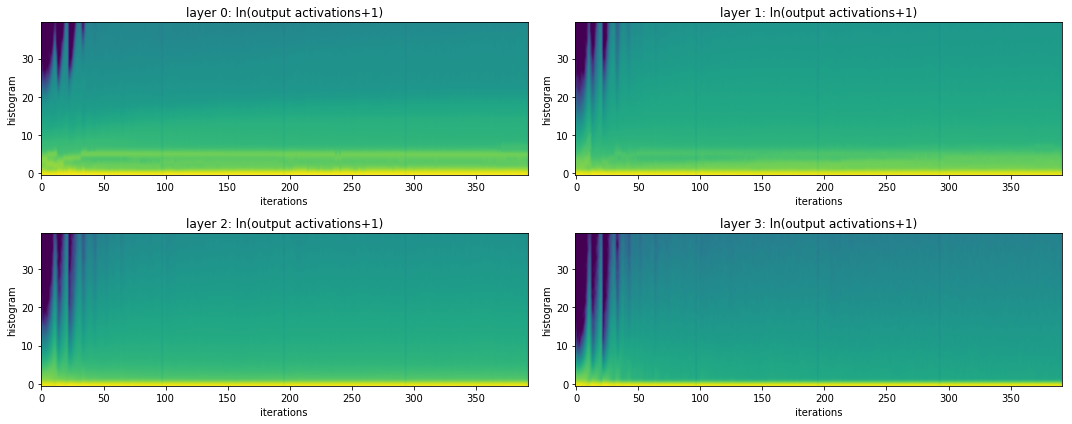

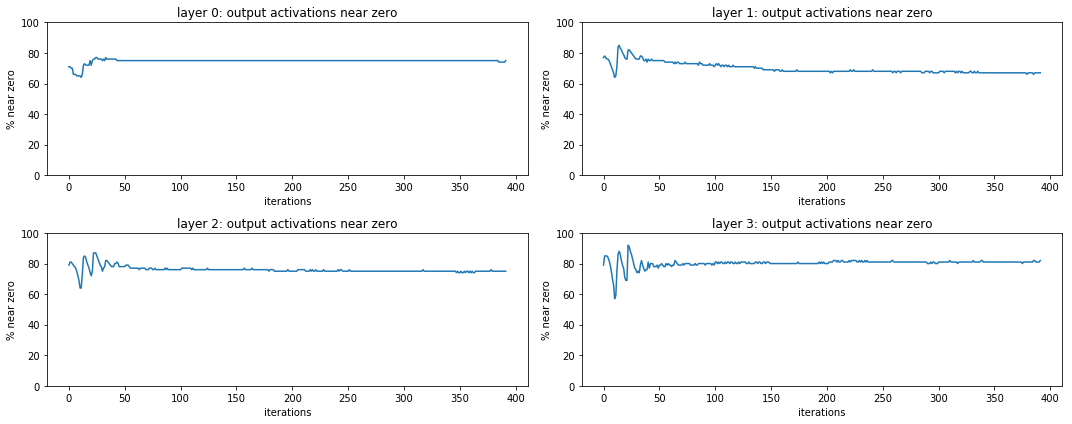

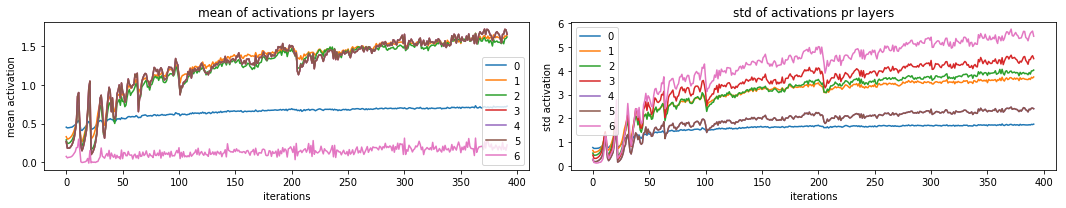

In [25]:
cbfs  = cbfs_base.copy() + [Recorder, partial(AvgStatsCallback,[accuracy]) ] 
model = get_cnn_model(layers_sizes, in_features, out_features, partial(conv_layer,bn=False) )
init_cnn(model)
learn = Learner( model, data, loss_func,opt=sgd_opt(model.parameters(),lr=0.4), cb_funcs=cbfs)

with Hooks(model, append_stats) as hooks: 
    learn.fit(4)
    plot_layer_stats( hooks )

## mnist with hooks + kaiming initialization + batchnorm

train: [0.750372421875, tensor(0.8033)]
valid: [0.1852794189453125, tensor(0.9494)]
train: [0.1487119140625, tensor(0.9586)]
valid: [0.1122181884765625, tensor(0.9695)]
train: [0.097945771484375, tensor(0.9718)]
valid: [0.08463890380859375, tensor(0.9771)]
train: [0.0772869189453125, tensor(0.9776)]
valid: [0.08439583740234376, tensor(0.9767)]


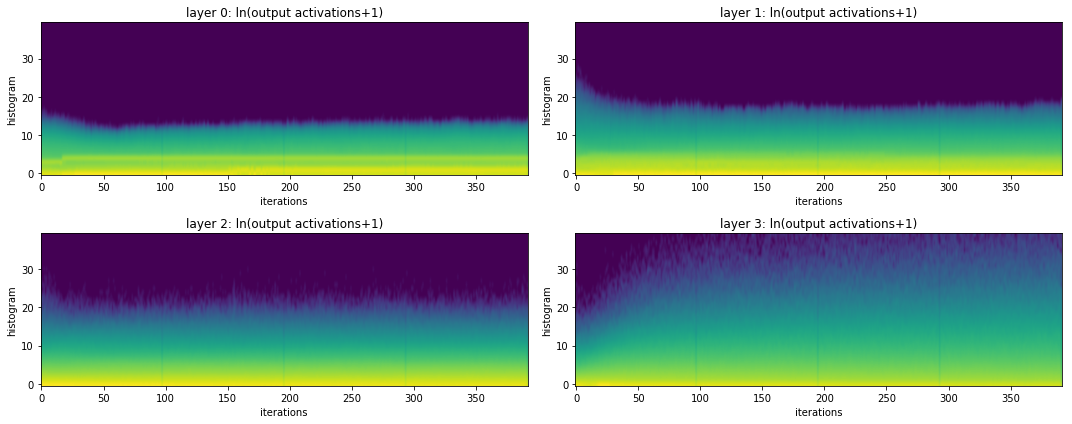

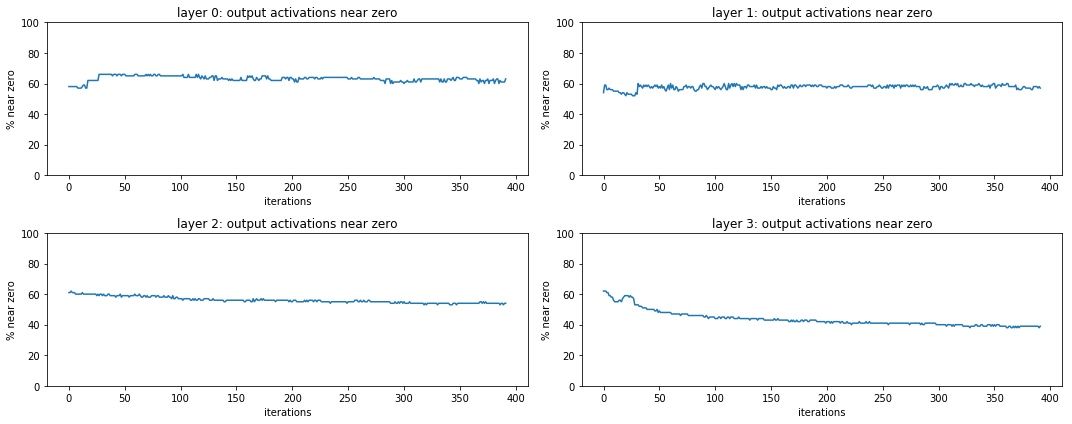

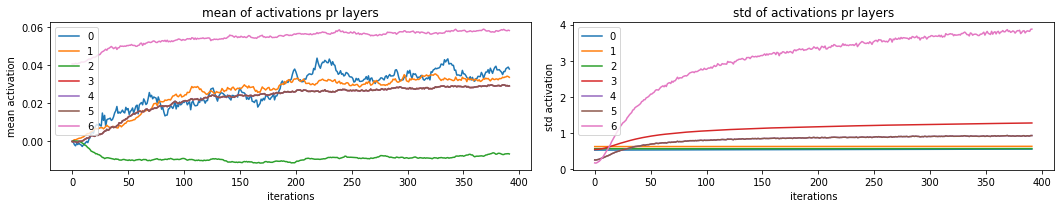

In [26]:
cbfs  = cbfs_base.copy() + [Recorder, partial(AvgStatsCallback,[accuracy]) ] 
model = get_cnn_model(layers_sizes, in_features, out_features, partial(conv_layer,bn=True) )
init_cnn(model)
learn = Learner( model, data, loss_func,opt=sgd_opt(model.parameters(),lr=0.4), cb_funcs=cbfs)

with Hooks(model, append_stats) as hooks: 
    learn.fit(4)
    plot_layer_stats( hooks )